In [111]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

In [112]:
endTime = dt.datetime.now()
startTime = dt.datetime(endTime.year - 1, endTime.month, endTime.day)

df = yf.download("BTC-USD", startTime, endTime)

[*********************100%%**********************]  1 of 1 completed


In [113]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-03-05,22354.144531,22613.685547,22307.142578,22435.513672,22435.513672,13317001733
2023-03-06,22436.816406,22584.292969,22331.314453,22429.757812,22429.757812,17353192895
2023-03-07,22428.322266,22527.417969,22011.261719,22219.769531,22219.769531,22765452204
2023-03-08,22216.441406,22268.896484,21708.050781,21718.080078,21718.080078,22536575684
2023-03-09,21720.080078,21802.716797,20210.306641,20363.021484,20363.021484,30364664171


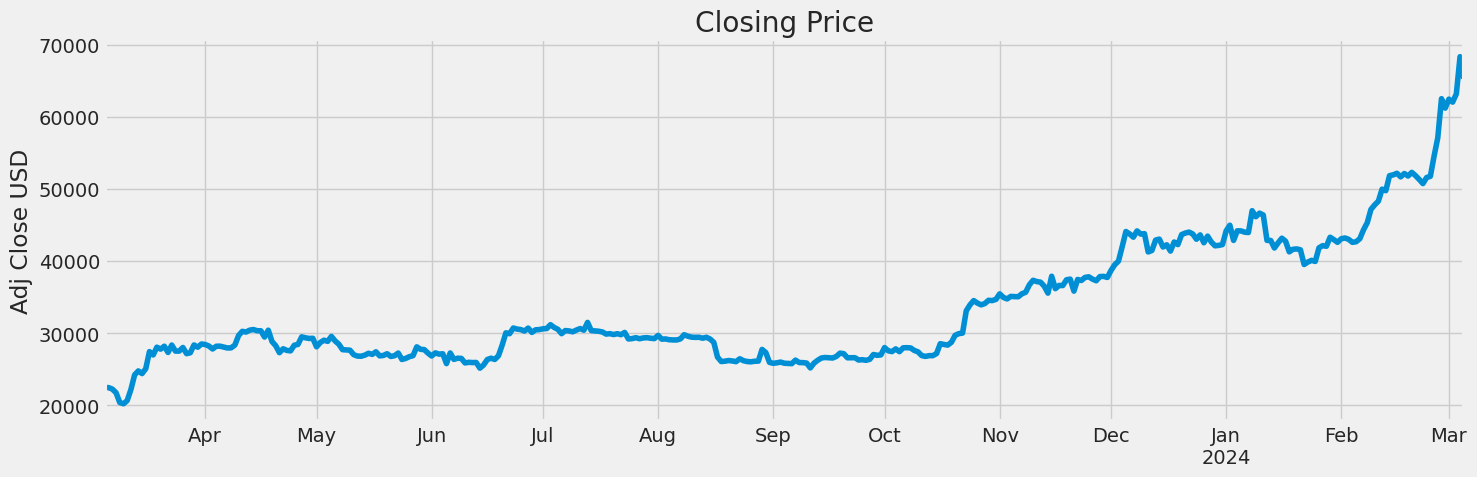

In [114]:
plt.figure(figsize=(15, 5))
plt.subplots_adjust(top=1.25, bottom=1.2)

df['Adj Close'].plot()
plt.ylabel('Adj Close USD')
plt.xlabel(None)
plt.title("Closing Price")

plt.tight_layout()

In [115]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Create a new dataframe with only the price column
data = df.filter(["Date", "Adj Close"]).reset_index()
# Convert the dataframe to a numpy array
dataset = data.filter(["Adj Close"]).values

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [116]:
# Get the number of rows to train the model on
training_data_len = int(np.ceil(len(scaled_data) * .95 ))
# Create the training data set
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [126]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, Dropout

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(25))
#model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=5)

Epoch 1/5
289/289 [==============================] - 13s 37ms/step - loss: 0.0028
Epoch 2/5
289/289 [==============================] - 11s 37ms/step - loss: 0.0016
Epoch 3/5
289/289 [==============================] - 11s 37ms/step - loss: 0.0011
Epoch 4/5
289/289 [==============================] - 12s 40ms/step - loss: 8.9732e-04
Epoch 5/5
289/289 [==============================] - 11s 37ms/step - loss: 8.0415e-04


In [127]:
# Create the testing data set
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the models predicted values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

1/1 [==============================] - 1s 652ms/step


2196.311808428105

<ipython-input-128-c9e1abdcf7bb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


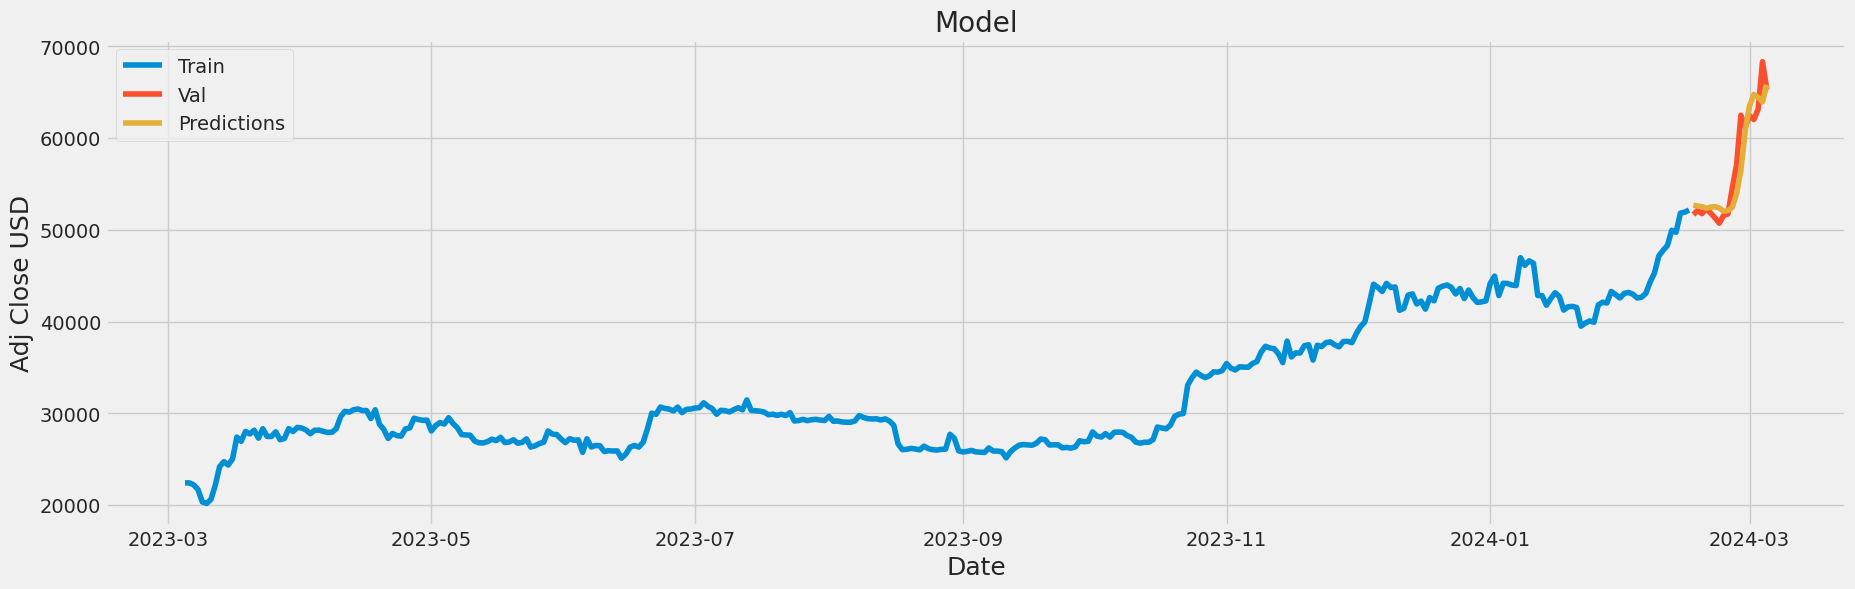

In [128]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(20,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Adj Close USD', fontsize=18)
plt.plot(train["Date"], train['Adj Close'])
plt.plot(valid["Date"], valid[['Adj Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='upper left')
plt.show()